##### 6.6 Sourcing & Analyzing Time-Series Data

##### This script contains the following:
##### 1. Importing libraries and data
##### 2. Subsetting, wrangling, and cleaning time-series data
##### 3. Time series analysis: decomposition
##### 4. Testing for stationarity
##### 5. Stationarizing the OPEC Crude Oil Price

##### 1. Importing your libraries and data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'dWZk1mWvPH91PdTq1LRm'

In [3]:
# Importing the Organization of the Petroleum Exporting Countries "OPEC Crude Oil Price" variable.

data = quandl.get('OPEC/ORB')

In [4]:
data.head(5)

,Value
Date,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [5]:
data.shape

(5322, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

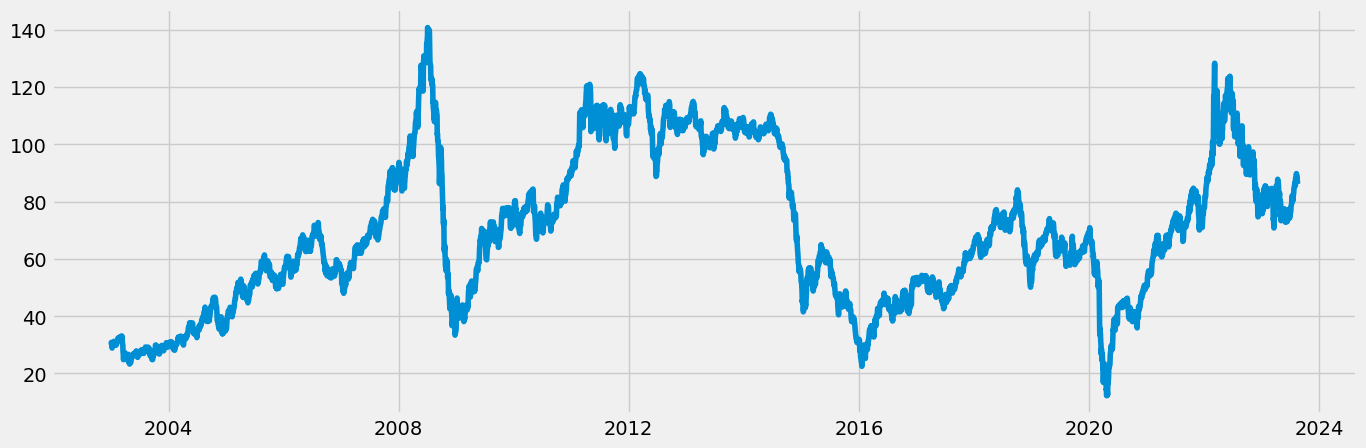

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

##### 2. Subsetting, wrangling, and cleaning time-series data

In [16]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [17]:
data_2.head()

,Date,Value
0,2003-01-02,30.05
1,2003-01-03,30.83
2,2003-01-06,30.71
3,2003-01-07,29.72
4,2003-01-08,28.86


In [21]:
# Set the "Date" column as the index

from datetime import datetime

data_2['datetime'] = pd.to_datetime(data_2['Date']) # Create a datetime column from "Date.""
data_2 = data_2.set_index('datetime') # Set the datetime as the index of the dataframe.
data_2.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_2.head()

,Value
datetime,
2003-01-02,30.05
2003-01-03,30.83
2003-01-06,30.71
2003-01-07,29.72
2003-01-08,28.86


In [22]:
# Check for missing values.

data_2.isnull().sum() 

Value    0
dtype: int64

In [23]:
# Check for duplicates.

dups = data_2.duplicated()
dups.sum()

# The dataset contains 1339 duplicate

1339

In [28]:
#Removing the duplicated value and assigning to df_prods_clean_no_dups
data_clean = data_2.drop_duplicates()

In [29]:
data_clean.shape

(3983, 1)

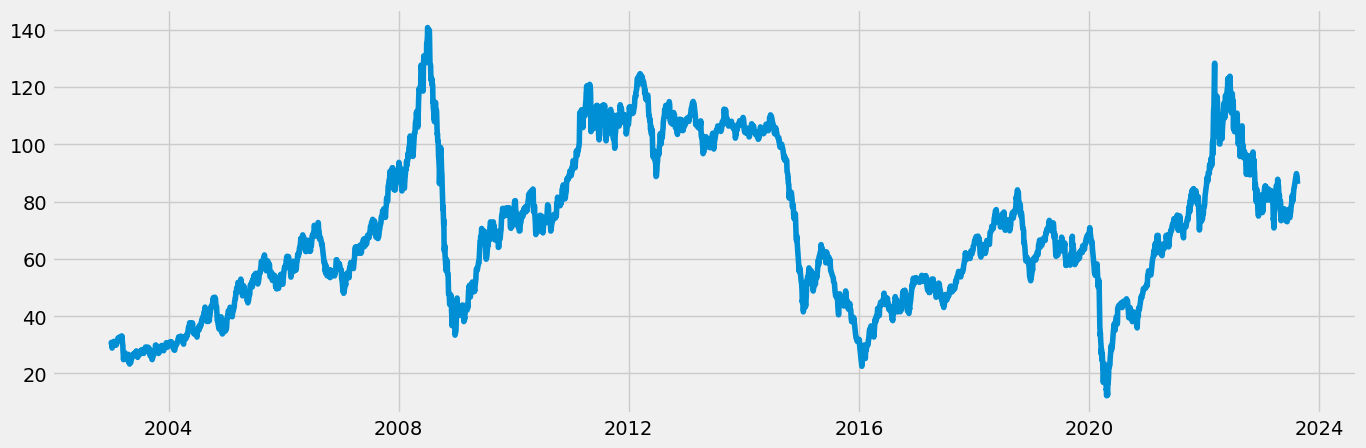

In [30]:
# Plot the new data set after removing duplicate

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_clean)

##### 3. Time-series analysis: decomposition

In [32]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_clean, model='additive', period= 365)

In [33]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

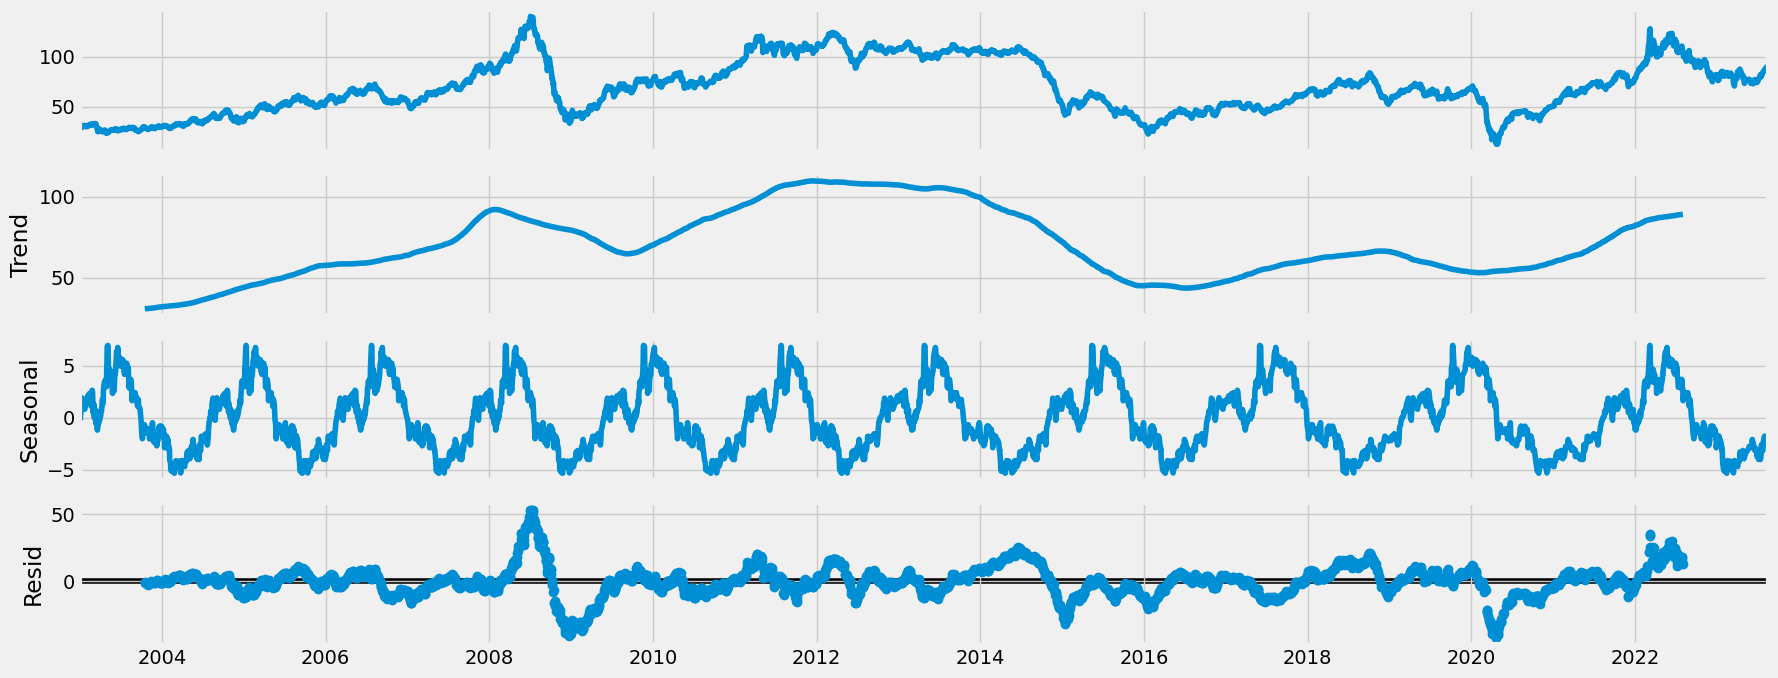

In [34]:
# Plot the separate components

decomposition.plot()
plt.show()

##### 4. Testing for stationarity

In [35]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_clean['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   -2.828181
p-value                           0.054360
Number of Lags Used              26.000000
Number of Observations Used    3956.000000
Critical Value (1%)              -3.432004
Critical Value (5%)              -2.862271
Critical Value (10%)             -2.567159
dtype: float64



##### The test statistics -2.828181 is larger than the critical level(-2.862271) at 5% p value significate level, we can not reject the null hypothesis, which indicate presence of a unit root and the data is non-stationary.

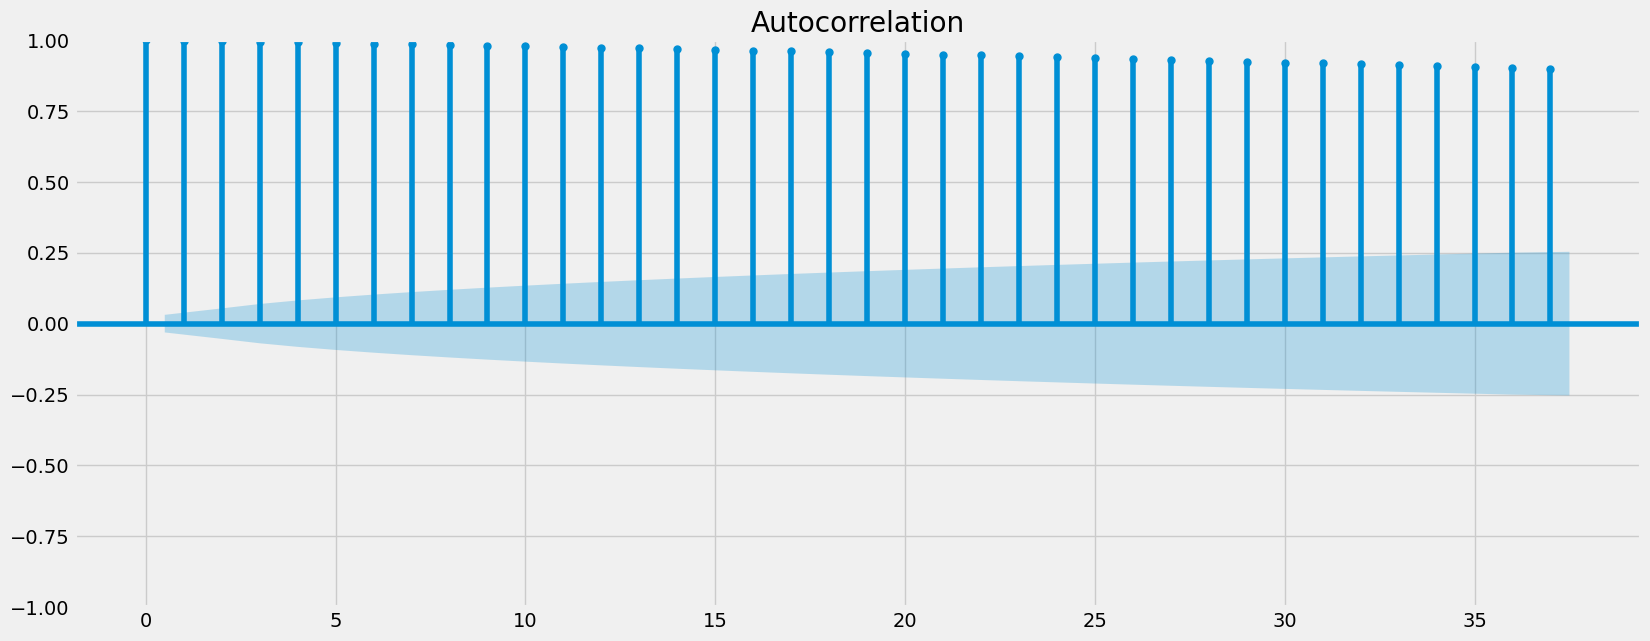

In [36]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_clean)
plt.show()

##### All the lags are above the confidence level, this indicate the lags that are significantly correlated with each other. 

##### 5. Stationarizing the Federal Reserve Economic Data

In [37]:
data_diff = data_clean - data_clean.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [38]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [39]:
data_diff.head()

,Value
datetime,
2003-01-03,0.78
2003-01-06,-0.12
2003-01-07,-0.99
2003-01-08,-0.86
2003-01-09,0.65


In [40]:
data_diff.columns

Index(['Value'], dtype='object')

In [43]:
# Check for missing values (you shouldn't have any)

data_diff.isnull().sum() 

Value    0
dtype: int64

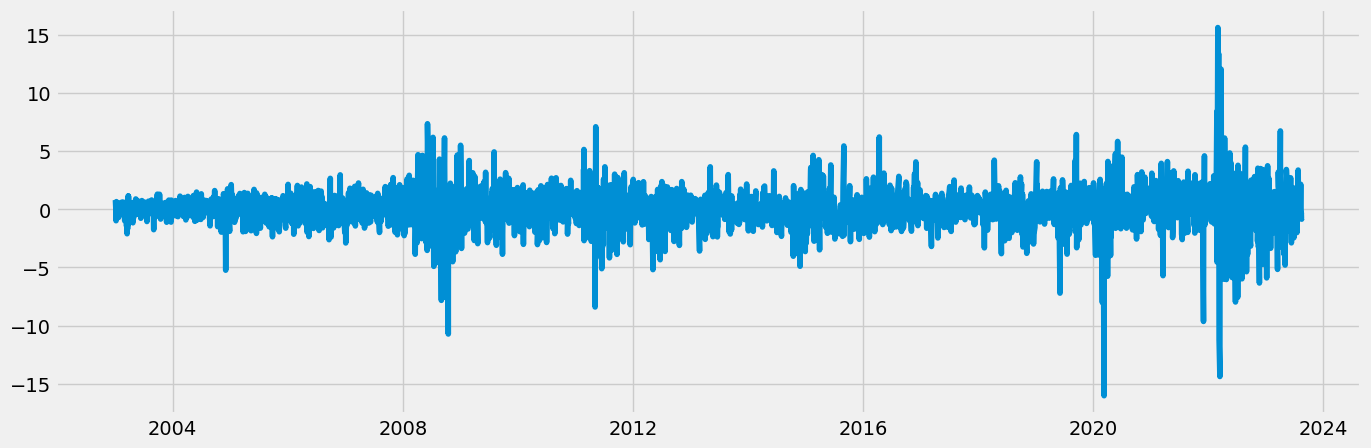

In [41]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [42]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -9.903587e+00
p-value                        3.308248e-17
Number of Lags Used            2.600000e+01
Number of Observations Used    3.955000e+03
Critical Value (1%)           -3.432005e+00
Critical Value (5%)           -2.862271e+00
Critical Value (10%)          -2.567159e+00
dtype: float64


##### The test statistic -9.90 is less than the critical value -2.86 at pvalue 0,05 significant level. we can now reject the null hypothesis and it shows our series is now stationary 

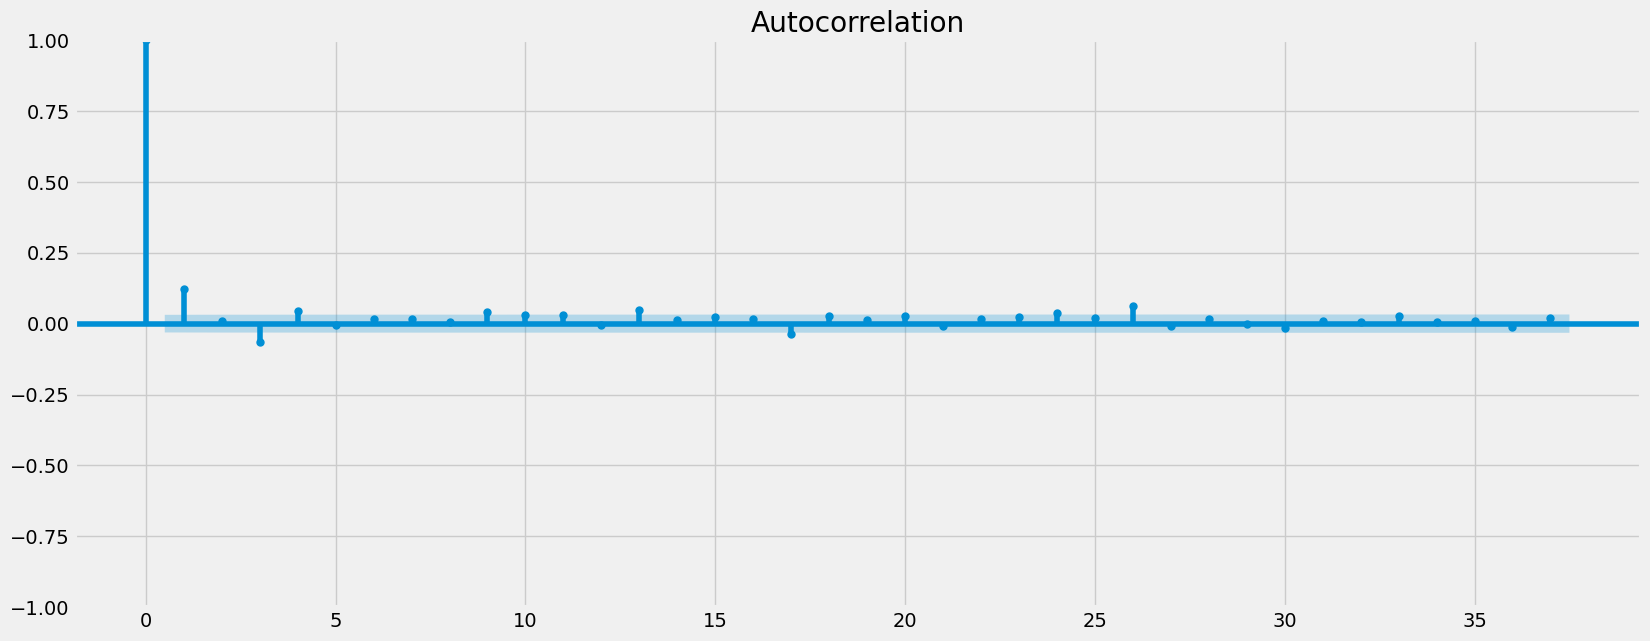

In [44]:
plot_acf(data_diff)
plt.show()

##### Dickey-Fuller test saying our data is stationary and we have 1 autocorrelated lag